In [ ]:
import torch, os
import pandas as pd
import numpy as np

import torch
from scipy import stats

import gseapy as gp
import time

import seaborn as sns
import matplotlib
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt
%matplotlib inline

from procyon.data.data_utils import DATA_DIR

In [ ]:
protein_info = pd.read_pickle(DATA_DIR+"integrated_data/v1/protein/protein_info_filtered.pkl")
go_info = pd.read_pickle(DATA_DIR+"integrated_data/v1/go/go_info_filtered.pkl")
uniprot_annot_scores = (
    pd.read_csv(DATA_DIR+f"experimental_data/function_retrieval/uniprot_annotation_scores.csv").
    rename(columns={"From":"uniprot_id_procyon", "Entry":"uniprot_id_updated"}).
    drop(columns=["Length"]).query("Annotation <= 3").query("uniprot_id_procyon in @protein_info.protein_id.values")
)

# Get retrieval scores

In [ ]:
# NOTE: Get ProCyon-Split retrieval scores from retrieval benchmark outputs
def get_preds(prompt_dataset, prompt_relation, split_shot):
    if split_shot.startswith("eval"):
        subdir_name = f"protein_{prompt_dataset}_{prompt_relation}_{split_shot}"
        output_dir = DATA_DIR+f"experimental_data/function_retrieval/retrieval_preds_eval/{subdir_name}"
    elif split_shot.startswith("CL_train"):
        subdir_name = f"protein_{prompt_dataset}_{prompt_relation}_{split_shot}"
        output_dir = DATA_DIR+f"experimental_data/function_retrieval/retrieval_preds_train/{subdir_name}"
    else:
        raise ValueError(f"split {split_shot} not recognized")
    
    preds_path = os.path.join(output_dir, "predictions.pkl")
    row_idx_path = os.path.join(output_dir, "row_idxs.tsv")
    col_idx_path = os.path.join(output_dir, "col_idxs.tsv")

    with open(preds_path, "rb") as fh:
        predictions = torch.load(fh)
    saved_query_order = pd.read_table(row_idx_path, names=["idx"]).idx.to_list()
    saved_target_order = pd.read_table(col_idx_path, names=["idx"]).idx.to_list()
    
    df = pd.DataFrame(predictions.numpy(), index=saved_query_order, columns=saved_target_order)
    df.index = go_info.loc[df.index, "go_id"]
    df.columns = protein_info.loc[df.columns, "protein_id"]

    return df

In [4]:
go_by_protein_df = pd.concat([get_preds("go", relation, split_shot) for split_shot in ["eval_zero_shot", "eval_five_shot", "eval_pt_ft", "CL_train"] for relation in ["process", "component", "function"]], axis=0)
go_by_protein_df = go_by_protein_df.reset_index().drop_duplicates("go_id").set_index("go_id")
go_by_protein_percentile_df = go_by_protein_df.apply(lambda x: x.rank(pct=True), axis=1)

Only consider proteins with annotation scores 2 or 3 and have protein- or transcript-level evidence of existence.

In [ ]:
protein_functions = pd.read_pickle(DATA_DIR+"integrated_data/v1/protein/uniprot_functional_descriptions.pkl")
protein_existence = pd.read_table(DATA_DIR+f"experimental_data/function_retrieval/uniprotkb_organism_id_9606_AND_reviewed_2025_03_04.tsv", sep="\t").rename(columns={"Entry":"uniprot_id_updated"})
valid_uniprots_for_ret = uniprot_annot_scores.query("uniprot_id_procyon in @go_by_protein_df.columns")
valid_uniprots_for_ret = set(valid_uniprots_for_ret[valid_uniprots_for_ret["uniprot_id_updated"].isin(protein_existence.query("`Protein existence` == 'Evidence at protein level' or `Protein existence` == 'Evidence at transcript level'")["uniprot_id_updated"].values)]["uniprot_id_procyon"].values)

Also make sure they don't have existing UniProt FUNCTION or GO or Reactome or EC annotations in our database

In [ ]:
protein_go = pd.read_csv(DATA_DIR + "integrated_data/v1/protein_go/sample_aware_ontology_go_centric/protein_go_relations.unified.csv")
domain_go = pd.read_csv(DATA_DIR + "integrated_data/v1/domain_go/sample_aware_ontology_go_centric/domain_go_relations.unified.csv")
protein_reactome = pd.read_csv(DATA_DIR + "integrated_data/v1/protein_reactome/random_reactome_centric/protein_reactome_relations.unified.csv")
protein_ec = pd.read_csv(DATA_DIR + "integrated_data/v1/protein_ec/hierarchy_aware_ec_centric/protein_ec_relations.unified.csv")
protein_omim = pd.read_csv(DATA_DIR + "integrated_data/v1/protein_omim/disgenet_aligned_improved_omim_centric/protein_omim_relations.unified.csv")
protein_disgenet = pd.read_csv(DATA_DIR + "integrated_data/v1/protein_disgenet/area_protein_aware_disgenet_centric/protein_disgenet_relations.unified.csv")
protein_drugbank = pd.read_csv(DATA_DIR + "integrated_data/v1/protein_drugbank/atc_aware_drugbank_centric/protein_drugbank_relations.unified.csv")
protein_gtop = pd.read_csv(DATA_DIR + "integrated_data/v1/protein_gtop/random_gtop_centric/protein_gtop_relations.unified.csv")

domain_pfam = pd.read_csv(DATA_DIR + "integrated_data/v1/domain_pfam/clan_aware_pfam_centric/domain_pfam_relations.unified.csv")
pfam_info = pd.read_pickle(DATA_DIR + "integrated_data/v1/pfam/pfam_info_filtered.pkl")
domain_pfam["uniprot_id"] = domain_pfam["seq_id"].apply(lambda x: x.split("_")[0])
domain_pfam = domain_pfam.merge(pfam_info[["short_name_pfam", "pfam_id"]], left_on="text_id", right_on="pfam_id", how="left").drop(columns=["pfam_id"])

In [9]:
valid_uniprots_for_ret &= set(protein_info[protein_info["comments"].apply(lambda x: "FUNCTION" not in x)]["protein_id"])
valid_uniprots_for_ret -= (
    set(protein_go["seq_id"].unique()) | 
    set(protein_reactome["seq_id"].unique()) | 
    set(protein_ec["seq_id"].unique()) | 
    set(protein_omim["seq_id"].unique()) |
    set(protein_disgenet["seq_id"].unique()) |
    set(protein_drugbank["seq_id"].unique()) |
    set(protein_gtop["seq_id"].unique()) |
    set(domain_go["seq_id"].apply(lambda x: x.split("_")[0]).unique()) | 
    set(domain_pfam[((domain_pfam["split"] == "CL_train") | (domain_pfam["split"].str.startswith("CL_val"))) & ~(domain_pfam["short_name_pfam"].str.startswith("DUF") | domain_pfam["short_name_pfam"].str.startswith("UPF"))]["uniprot_id"].unique())
)
len(valid_uniprots_for_ret)

540

In [10]:
go_by_protein_df_filtered = go_by_protein_df.loc[:, list(valid_uniprots_for_ret)]
go_by_protein_percentile_df_filtered = go_by_protein_df.apply(lambda x: x.rank(pct=True), axis=1).loc[:, list(valid_uniprots_for_ret)]
go_by_protein_percentile_df_filtered

protein_id,O75391,A1L170,A2RRH5,A6NML5,Q8IYW4,Q9BX51,P0DUQ1,Q6UWP8,Q9NQR7,Q9BQE6,...,Q8TEF2,Q6IPW1,Q96ET8,Q7Z5D8,C9J7I0,Q6MZM9,Q6L9T8,Q6ZSJ8,Q0VAA5,Q569G3
go_id,,,,,,,,,,,,,,,,,,,,,
GO:0000209,0.570650,0.486437,0.781914,0.022202,0.852702,0.095026,0.996038,0.408248,0.159679,0.322769,...,0.115192,0.185127,0.717261,0.184604,0.872400,0.120062,0.956889,0.536536,0.489573,0.467151
GO:0016567,0.586910,0.509299,0.821531,0.016232,0.871162,0.019286,0.988473,0.269506,0.432871,0.331077,...,0.122758,0.279988,0.548476,0.269506,0.844256,0.057912,0.942445,0.578161,0.299961,0.531336
GO:0032446,0.562149,0.279410,0.749312,0.011500,0.740784,0.136816,0.998184,0.374574,0.094861,0.368548,...,0.092467,0.153736,0.559288,0.331848,0.785710,0.174645,0.962584,0.594421,0.542368,0.490563
GO:0070647,0.501128,0.261390,0.722818,0.012078,0.747606,0.142869,0.996699,0.409651,0.095136,0.333553,...,0.097392,0.136486,0.545119,0.297788,0.785683,0.223314,0.956394,0.622703,0.498872,0.496011
GO:0006486,0.285518,0.283207,0.285518,0.068780,0.770964,0.564405,0.342880,0.755475,0.010867,0.335754,...,0.302850,0.072796,0.713107,0.034252,0.682238,0.867833,0.107846,0.848327,0.584131,0.435980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:0034593,0.242957,0.619566,0.827501,0.146418,0.974029,0.308435,0.303758,0.391246,0.251155,0.294101,...,0.332013,0.294101,0.883928,0.051420,0.739738,0.114504,0.288709,0.278502,0.771074,0.169198
GO:0052866,0.363156,0.926956,0.860102,0.338148,0.973534,0.425140,0.188236,0.331380,0.256795,0.699021,...,0.676543,0.525889,0.945884,0.040745,0.872373,0.089276,0.549494,0.558298,0.968224,0.227495
GO:1904047,0.871932,0.082893,0.719957,0.008199,0.347915,0.005915,0.329867,0.436503,0.222543,0.719957,...,0.023000,0.193243,0.166887,0.897628,0.451579,0.076345,0.380351,0.655882,0.161439,0.554638


# Validate with perturb-seq data (Replogle et al., 2022)

## Process those p values

In [11]:
replogle_pvals = pd.read_csv(DATA_DIR + "experimental_data/function_retrieval/replogle_andersondarlingpvaluesBHcorrected.csv", index_col=0)
replogle_pvals

,1946_CTSC_P1P2_ENSG00000109861,1973_CWC25_P1P2_ENSG00000273559,6168_PDE4DIP_ENST00000313431.9_ENSG00000178104,10745_ZZEF1_P1P2_ENSG00000074755,8210_SNAPIN_P1P2_ENSG00000143553,7183_RBM6_P1P2_ENSG00000004534,2209_DHX33_P1P2_ENSG00000005100,4383_KIF1C_P1P2_ENSG00000129250,9904_XRCC2_P1P2_ENSG00000196584,863_BNIP2_P1P2_ENSG00000140299,...,7785_SEPTIN2_P1P2_ENSG00000168385,1812_COX19_P1P2_ENSG00000240230,1165_CAMKK2_P1P2_ENSG00000110931,10751_non-targeting_non-targeting_non-targeting,4651_LRP8_P1P2_ENSG00000157193,3054_FECH_P1P2_ENSG00000066926,2932_RIPOR1_P1_ENSG00000039523,5927_OGDH_P1P2_ENSG00000105953,4908_MCOLN1_P1P2_ENSG00000090674,10623_ZNF774_P1P2_ENSG00000196391
ENSG00000188976,0.867552,0.430562,0.873442,0.999999,0.999759,0.924248,1.203808e-01,0.996171,0.751438,0.967091,...,0.791199,0.549808,0.998982,0.762158,0.974040,0.566381,0.245242,0.990177,0.843924,0.945298
ENSG00000187608,0.953630,0.547279,0.954249,0.999999,0.999759,0.973994,2.311177e-02,0.996171,0.706745,0.941343,...,0.991708,0.973457,0.998982,0.906866,0.900957,0.362616,0.157488,0.990177,0.969598,0.945298
ENSG00000078808,0.999979,0.305927,0.953442,0.999999,0.999759,0.978897,2.410149e-01,0.996171,0.839022,0.961746,...,0.920458,0.702266,0.998982,0.975516,0.739412,0.489311,0.448953,0.990177,0.920719,0.945298
ENSG00000176022,0.867552,0.727233,0.873442,0.999999,0.999759,0.973994,2.464980e-01,0.996171,0.742458,0.967091,...,0.948912,0.958336,0.998982,0.930972,0.849226,0.654942,0.602637,0.990177,0.984304,0.945298
ENSG00000160087,0.999979,0.669874,0.953442,0.999999,0.999759,0.993345,3.392636e-02,0.996171,0.751438,0.936442,...,0.823062,0.765245,0.998982,0.997819,0.818921,0.511749,0.877782,0.992603,0.926393,0.945298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198886,0.999781,0.669874,0.996155,0.999999,0.999759,0.000006,5.519925e-02,0.996171,0.683075,0.947554,...,0.997141,0.144366,0.998982,0.975516,0.691560,0.839389,0.367222,0.678821,0.924330,0.945298
ENSG00000198786,0.999781,0.449864,0.953442,0.999999,0.999759,0.537984,2.285437e-02,0.996171,0.799924,0.936442,...,0.866792,0.954650,0.998982,0.975516,0.828086,0.732529,0.110858,0.990177,0.985247,0.947002
ENSG00000198695,0.860812,0.621864,0.953442,0.999999,0.999759,0.342231,7.903662e-02,0.996171,0.683075,0.971735,...,0.963235,0.816324,0.998982,0.813192,0.779555,0.905560,0.115298,0.990177,0.877056,0.945298
ENSG00000198727,0.941694,0.547279,0.913687,0.999999,0.999759,0.000490,1.677256e-12,0.996171,0.431926,0.971320,...,0.802537,0.552861,0.998982,0.960355,0.796490,0.555116,0.265059,0.990177,0.735930,0.946862


Map ENSG in the data to UniProt to our database

In [ ]:
uniprot_id_mappings = pd.read_table(DATA_DIR + "experimental_data/function_retrieval/HUMAN_9606_idmapping.dat", sep="\t", header=None)
uniprot_id_mappings.columns = ["uniprot_id", "id_type", "id"]
uniprot_id_mappings = uniprot_id_mappings.query("id_type == 'Gene_Name' or id_type == 'Ensembl' or id_type == 'GeneID'")
uniprot_id_mappings["id"] = uniprot_id_mappings["id"].str.split(".").str[0]

gene_name_to_uniprot_id = uniprot_id_mappings.query("id_type == 'Gene_Name'").drop_duplicates().drop(columns=["id_type"])
ensg_to_uniprot_id = uniprot_id_mappings.query("id_type == 'Ensembl'").drop_duplicates().drop(columns=["id_type"])

gene_name_to_uniprot_id = gene_name_to_uniprot_id.query("uniprot_id in @protein_info.protein_id.values").groupby("id").agg(set)["uniprot_id"]
ensg_to_uniprot_id = ensg_to_uniprot_id.query("uniprot_id in @protein_info.protein_id.values").groupby("id").agg(set)["uniprot_id"]

In [13]:
replogle_pvals_columns = [
    (
        (gene_name_to_uniprot_id[col.split("_")[1]], )
        if col.split("_")[1] in gene_name_to_uniprot_id.index 
        else (None, )
    ) + 
    (
        (ensg_to_uniprot_id[col.split("_")[-1]], )
        if col.split("_")[-1] in ensg_to_uniprot_id.index 
        else (None, )
    )
    for col in replogle_pvals.columns
]

replogle_pvals_columns = [list(set(list(tup[0] if tup[0] is not None else []) + list(tup[1] if tup[1] is not None else []))) for tup in replogle_pvals_columns]
replogle_pvals_filtered = pd.DataFrame(pd.Series(replogle_pvals_columns)).T
replogle_pvals_filtered.columns = replogle_pvals.columns
replogle_pvals_filtered = pd.concat([
    replogle_pvals,
    replogle_pvals_filtered,
], axis=0).T
replogle_pvals_filtered = replogle_pvals_filtered.explode(0).dropna(subset=[0]).set_index(0).rename_axis(index=None)
replogle_pvals_filtered

,ENSG00000188976,ENSG00000187608,ENSG00000078808,ENSG00000176022,ENSG00000160087,ENSG00000169972,ENSG00000127054,ENSG00000175756,ENSG00000221978,ENSG00000224870,...,ENSG00000228253,ENSG00000198899,ENSG00000198938,ENSG00000198840,ENSG00000212907,ENSG00000198886,ENSG00000198786,ENSG00000198695,ENSG00000198727,ENSG00000276345
P53634,0.867552,0.95363,0.999979,0.867552,0.999979,0.798209,0.953926,0.885374,0.954473,0.999781,...,0.999781,0.999781,0.999781,0.952808,0.775853,0.999781,0.999781,0.860812,0.941694,0.999979
Q9NXE8,0.430562,0.547279,0.305927,0.727233,0.669874,0.547279,0.602554,0.715303,0.875423,0.649948,...,0.789641,0.586822,0.43868,0.872465,0.72158,0.669874,0.449864,0.621864,0.547279,0.741555
O43149,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,...,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999
O95295,0.999759,0.999759,0.999759,0.999759,0.999759,0.999759,0.999759,0.999759,0.999759,0.999759,...,0.999759,0.999759,0.999759,0.999759,0.999759,0.999759,0.999759,0.999759,0.999759,0.999759
P78332,0.924248,0.973994,0.978897,0.973994,0.993345,0.968598,0.957904,0.60678,0.975138,0.981427,...,0.998739,0.000311,0.98562,0.981724,0.841432,0.000006,0.537984,0.342231,0.00049,0.973287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P22830,0.566381,0.362616,0.489311,0.654942,0.511749,0.19244,0.499741,0.66482,0.52954,0.962869,...,0.729922,0.744878,0.196313,0.986122,0.456615,0.839389,0.732529,0.90556,0.555116,0.167338
Q6ZS17,0.245242,0.157488,0.448953,0.602637,0.877782,0.431441,0.191804,0.276231,0.387308,0.317719,...,0.078159,0.111591,0.037031,0.096284,0.13002,0.367222,0.110858,0.115298,0.265059,0.264426
Q02218,0.990177,0.990177,0.990177,0.990177,0.992603,0.990177,0.990177,0.990177,0.990177,0.990177,...,0.990177,0.990177,0.990177,0.990177,0.990177,0.678821,0.990177,0.990177,0.990177,0.990177
Q9GZU1,0.843924,0.969598,0.920719,0.984304,0.926393,0.971027,0.824808,0.987369,0.637914,0.888264,...,0.985733,0.990855,0.779712,0.709433,0.971027,0.92433,0.985247,0.877056,0.73593,0.982774


In [ ]:
import mygene

mg = mygene.MyGeneInfo()
ensg_list = replogle_pvals_filtered.columns.values.tolist()
gene_info = mg.querymany(ensg_list, scopes='ensembl.gene', fields='symbol', species='human')
gene_symbols = [item['symbol'] if 'symbol' in item else None for item in gene_info]
replogle_pvals_filtered.columns = gene_symbols
replogle_pvals_filtered = replogle_pvals_filtered.drop(columns=[None])

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
6 input query terms found no hit:	['ENSG00000269028', 'ENSG00000112096', 'ENSG00000168078', 'ENSG00000130723', 'ENSG00000255823', 'ENS


## Pathway over-representation analysis

### Protein-centric retrieval evaluation

In [16]:
num_significant_genes_threshold = 50

replogle_pvals_filtered_for_proteins_ret = replogle_pvals_filtered[replogle_pvals_filtered.index.isin(go_by_protein_df_filtered.columns.values)]
replogle_pvals_filtered_for_proteins_ret = replogle_pvals_filtered_for_proteins_ret.loc[(replogle_pvals_filtered_for_proteins_ret < 0.05).sum(1) >= num_significant_genes_threshold, :]
replogle_pvals_filtered_for_proteins_ret

,NOC2L,ISG15,SDF4,B3GALT6,UBE2J2,PUSL1,INTS11,AURKAIP1,CCNL2,MRPL20-AS1,...,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB
A0A1W2PQ72,0.414964,0.999683,0.616537,0.990317,0.999683,0.978226,0.999683,0.972985,0.999683,0.943247,...,0.394432,0.990298,0.02593,0.000015,0.0,0.007237,0.015881,0.712988,0.543085,0.003182
Q86T20,0.573085,0.514852,0.605017,0.934659,0.962676,0.85995,0.349277,0.840359,0.440952,0.230177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q9H0W7,0.727043,0.742155,0.858284,0.805569,0.801385,0.401373,0.571535,0.7355,0.827959,0.647709,...,0.638894,0.843579,0.847172,0.85167,0.159807,0.651959,0.941509,0.438382,0.628554,0.795886
Q9Y4E6,0.289961,0.249054,0.473896,0.685458,0.327453,0.913848,0.898804,0.058457,0.065533,0.770787,...,0.0,0.115566,0.120894,0.642208,0.402037,0.243342,0.0,0.379999,0.110407,0.113512
P0DMU8,0.678928,0.321333,0.743465,0.568952,0.627842,0.92947,0.82675,0.867198,0.990793,0.201965,...,0.000213,0.989279,0.000038,0.050001,0.010257,0.067936,0.917718,0.371533,0.992906,0.658177
Q6PH81,0.972766,0.142076,0.122156,0.579569,0.768945,0.967451,0.469826,0.400943,0.557602,0.551337,...,0.028562,0.801642,0.020997,0.100716,0.936324,0.451725,0.000349,0.499157,0.010192,0.574222
O75391,0.384188,0.604734,0.506613,0.965234,0.215899,0.282478,0.221949,0.145991,0.454638,0.77599,...,0.000001,0.138957,0.0,0.000007,0.016049,0.016152,0.0,0.0,0.00018,0.0
Q49AR2,0.879295,0.89237,0.965196,0.904683,0.783303,0.630907,0.046986,0.375746,0.891585,0.950084,...,0.82922,0.486291,0.00759,0.539992,0.725261,0.393221,0.760903,0.982182,0.714388,0.738256
Q8IXQ4,0.580922,0.732123,0.324413,0.630858,0.701456,0.455488,0.558892,0.783943,0.71588,0.707279,...,0.710863,0.542074,0.79012,0.580929,0.699448,0.929709,0.81789,0.711801,0.734522,0.36649
Q5U649,0.258509,0.682475,0.691737,0.95579,0.578006,0.794608,0.382171,0.034454,0.708124,0.622317,...,0.0,0.077697,0.0,0.0,0.000125,0.023929,0.00457,0.469708,0.002238,0.000024


Run ORA

In [ ]:
pathways_enriched = {}
for i, uniprot_id in enumerate(replogle_pvals_filtered_for_proteins_ret.index):
   print(f"Processing {i+1}/{len(replogle_pvals_filtered_for_proteins_ret.index)}: {uniprot_id}")
   # Run enrichment analysis against a specific gene set library (e.g., KEGG_2016)
   enr = gp.enrichr(
      gene_list=replogle_pvals_filtered_for_proteins_ret.loc[uniprot_id][replogle_pvals_filtered_for_proteins_ret.loc[uniprot_id] < 0.05].sort_values().index.values.tolist(),
      gene_sets=[
         DATA_DIR+f"experimental_data/function_retrieval/gene_sets/GO_Molecular_Function_2023.gmt", 
         DATA_DIR+f"experimental_data/function_retrieval/gene_sets/GO_Biological_Process_2023.gmt",
      ], 
      organism='Human',
      outdir='enrichr_results',  # results will be saved in this directory
      background=replogle_pvals_filtered_for_proteins_ret.columns.tolist(),
      no_plot=True,  # skip plotting
      cutoff=0.05
   )  # only return gene sets with adjusted p-value < 0.05
   pathways_enriched[uniprot_id] = enr.results
   time.sleep(0.1) 

Processing 1/11: A0A1W2PQ72
Processing 2/11: Q86T20
Processing 3/11: Q9H0W7
Processing 4/11: Q9Y4E6
Processing 5/11: P0DMU8
Processing 6/11: Q6PH81
Processing 7/11: O75391
Processing 8/11: Q49AR2
Processing 9/11: Q8IXQ4
Processing 10/11: Q5U649
Processing 11/11: Q32NC0


In [18]:
all_dfs = []
p_val_thr = 0.05
odds_ratio_thr = 2
overlap_thr = 3

for uniprot_id, df in pathways_enriched.items():
    df["uniprot_id"] = uniprot_id
    all_dfs.append(df[(df["Adjusted P-value"] < p_val_thr) & (df["Odds Ratio"] >= odds_ratio_thr) & (df["Overlap"].apply(lambda x: int(x.split("/")[0])) >= overlap_thr)][["uniprot_id", "Term"]])
    
all_oras = pd.concat(all_dfs, axis=0)
all_oras["go_id"] = all_oras["Term"].apply(lambda x: x.split("(")[-1].strip(")"))
all_oras = all_oras.drop(columns=["Term"])
all_oras = all_oras.groupby("uniprot_id").agg(list)["go_id"].to_dict()

We say a prioritized GO term is a hit, if the predicted GO term is in the ORA set or upstream to members in the ORA set. 

Thus, we need to filter the ORA set and the prioritization df such that:
1. The ORA set only contains GO terms that are in the priotization df or downstream to members of the prioritization df.
2. The prioritization df only contains GO terms that are in the ORA set or upstream to members of the ORA set.

In [19]:
all_go_ancestors = torch.load(DATA_DIR + "experimental_data/compositional_prompts/all_go_ancestors.pkl")
all_go_offsprings = torch.load(DATA_DIR + "experimental_data/compositional_prompts/all_go_offsprings.pkl")

Keep only GO terms for prioritization df that are tested in ORA or are upstream to members of ORA (i.e. GO's offsprings are in ORA)


In [ ]:
all_ora_candidate_go_ids = set()
for fname in [DATA_DIR+f"experimental_data/function_retrieval/gene_sets/GO_Molecular_Function_2023.gmt", DATA_DIR+f"experimental_data/function_retrieval/gene_sets/GO_Biological_Process_2023.gmt"]:
    go_ids = pd.read_table(fname, sep="\t\t", header=None)[0].apply(lambda x: x.split("(")[-1].strip(")")).values
    all_ora_candidate_go_ids |= set(go_ids)
    all_ora_candidate_go_ids |= set.union(*[all_go_ancestors[go_id] for go_id in go_ids])
    
go_by_protein_df_filtered_for_oras = go_by_protein_df_filtered.loc[go_by_protein_df_filtered.index.isin(all_ora_candidate_go_ids), :]
go_by_protein_percentile_df_filtered_for_oras = go_by_protein_percentile_df_filtered.loc[go_by_protein_percentile_df_filtered.index.isin(all_ora_candidate_go_ids), :]

/tmp/ipykernel_22490/3603055732.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  go_ids = pd.read_table(fname, sep="\t\t", header=None)[0].apply(lambda x: x.split("(")[-1].strip(")")).values
/tmp/ipykernel_22490/3603055732.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  go_ids = pd.read_table(fname, sep="\t\t", header=None)[0].apply(lambda x: x.split("(")[-1].strip(")")).values


Keep only ORA GO terms that are tested in the prioritization df or are downstream to members of the prioritization terms (i.e. GO's offsprings are in prioritization df);

Then keep only proteins that have some ORAs of this kind.

In [ ]:
all_oras_filtered = {uniprot_id: set(list(
    go_id for go_id in go_ids if len((set(all_go_ancestors[go_id]) | set([go_id])) & set(go_by_protein_df_filtered_for_oras.index.values)) > 0
)) for uniprot_id, go_ids in all_oras.items()}
all_oras_filtered = {k: v for k, v in all_oras_filtered.items() if len(v) > 0}

go_by_protein_df_filtered_for_oras = go_by_protein_df_filtered_for_oras.loc[:, list(all_oras_filtered.keys())]
go_by_protein_percentile_df_filtered_for_oras = go_by_protein_percentile_df_filtered_for_oras.loc[:, list(all_oras_filtered.keys())]

Rank protein-wide percentile of each GO term for each protein individually

In [ ]:
k = 100

plot_data = []
protein_titles = []
for i, uniprot_id in enumerate(go_by_protein_percentile_df_filtered_for_oras.columns):
    gos_ranked_by_ret = go_by_protein_percentile_df_filtered_for_oras[uniprot_id].sort_values(ascending=False).index[:k]
    
    go_ids_for_printing = gos_ranked_by_ret[:20]
    go_names_for_printing = [go_info.query("go_id == @go")["go_name"].values[0] for go in gos_ranked_by_ret if len((set([go]) | set(all_go_offsprings[go])) & set(all_oras_filtered[uniprot_id])) > 0][:10]
    
    protein_data = pd.DataFrame({
        "go_id": gos_ranked_by_ret,
        "ret_score": go_by_protein_percentile_df_filtered_for_oras[uniprot_id].loc[gos_ranked_by_ret].values,
        "ora_label": [len((set([go]) | set(all_go_offsprings[go])) & set(all_oras_filtered[uniprot_id])) > 0 for go in gos_ranked_by_ret],
    })
    protein_data["ora_label"] = protein_data["ora_label"].astype(int)
    
    # hypergeometric test
    p_val = stats.hypergeom.sf(
        protein_data["ora_label"].sum() - 1,  # number of hits
        len(set(go_by_protein_percentile_df_filtered_for_oras.index.values)),  # total number of GO terms
        len([go_id for go_id in go_by_protein_percentile_df_filtered_for_oras[uniprot_id].index if len(set(all_oras_filtered[uniprot_id]) & (set([go_id]) | set(all_go_offsprings[go_id]))) > 0]),  # total number of (ground truth) ORA terms
        min(k, go_by_protein_percentile_df_filtered_for_oras.shape[0]),  # top k
    )
    protein_data["protein_title"] = f"{uniprot_id} (" + (r"$p=$" + f"{p_val:.3f}" if p_val > 0.001 else r"$p<0.001$") + ")"

    plot_data.append(protein_data)

plot_data = pd.concat(plot_data, axis=0)

# Sort the data to ensure validated points appear on top
plot_data = plot_data.sort_values(["protein_title", "ora_label"])

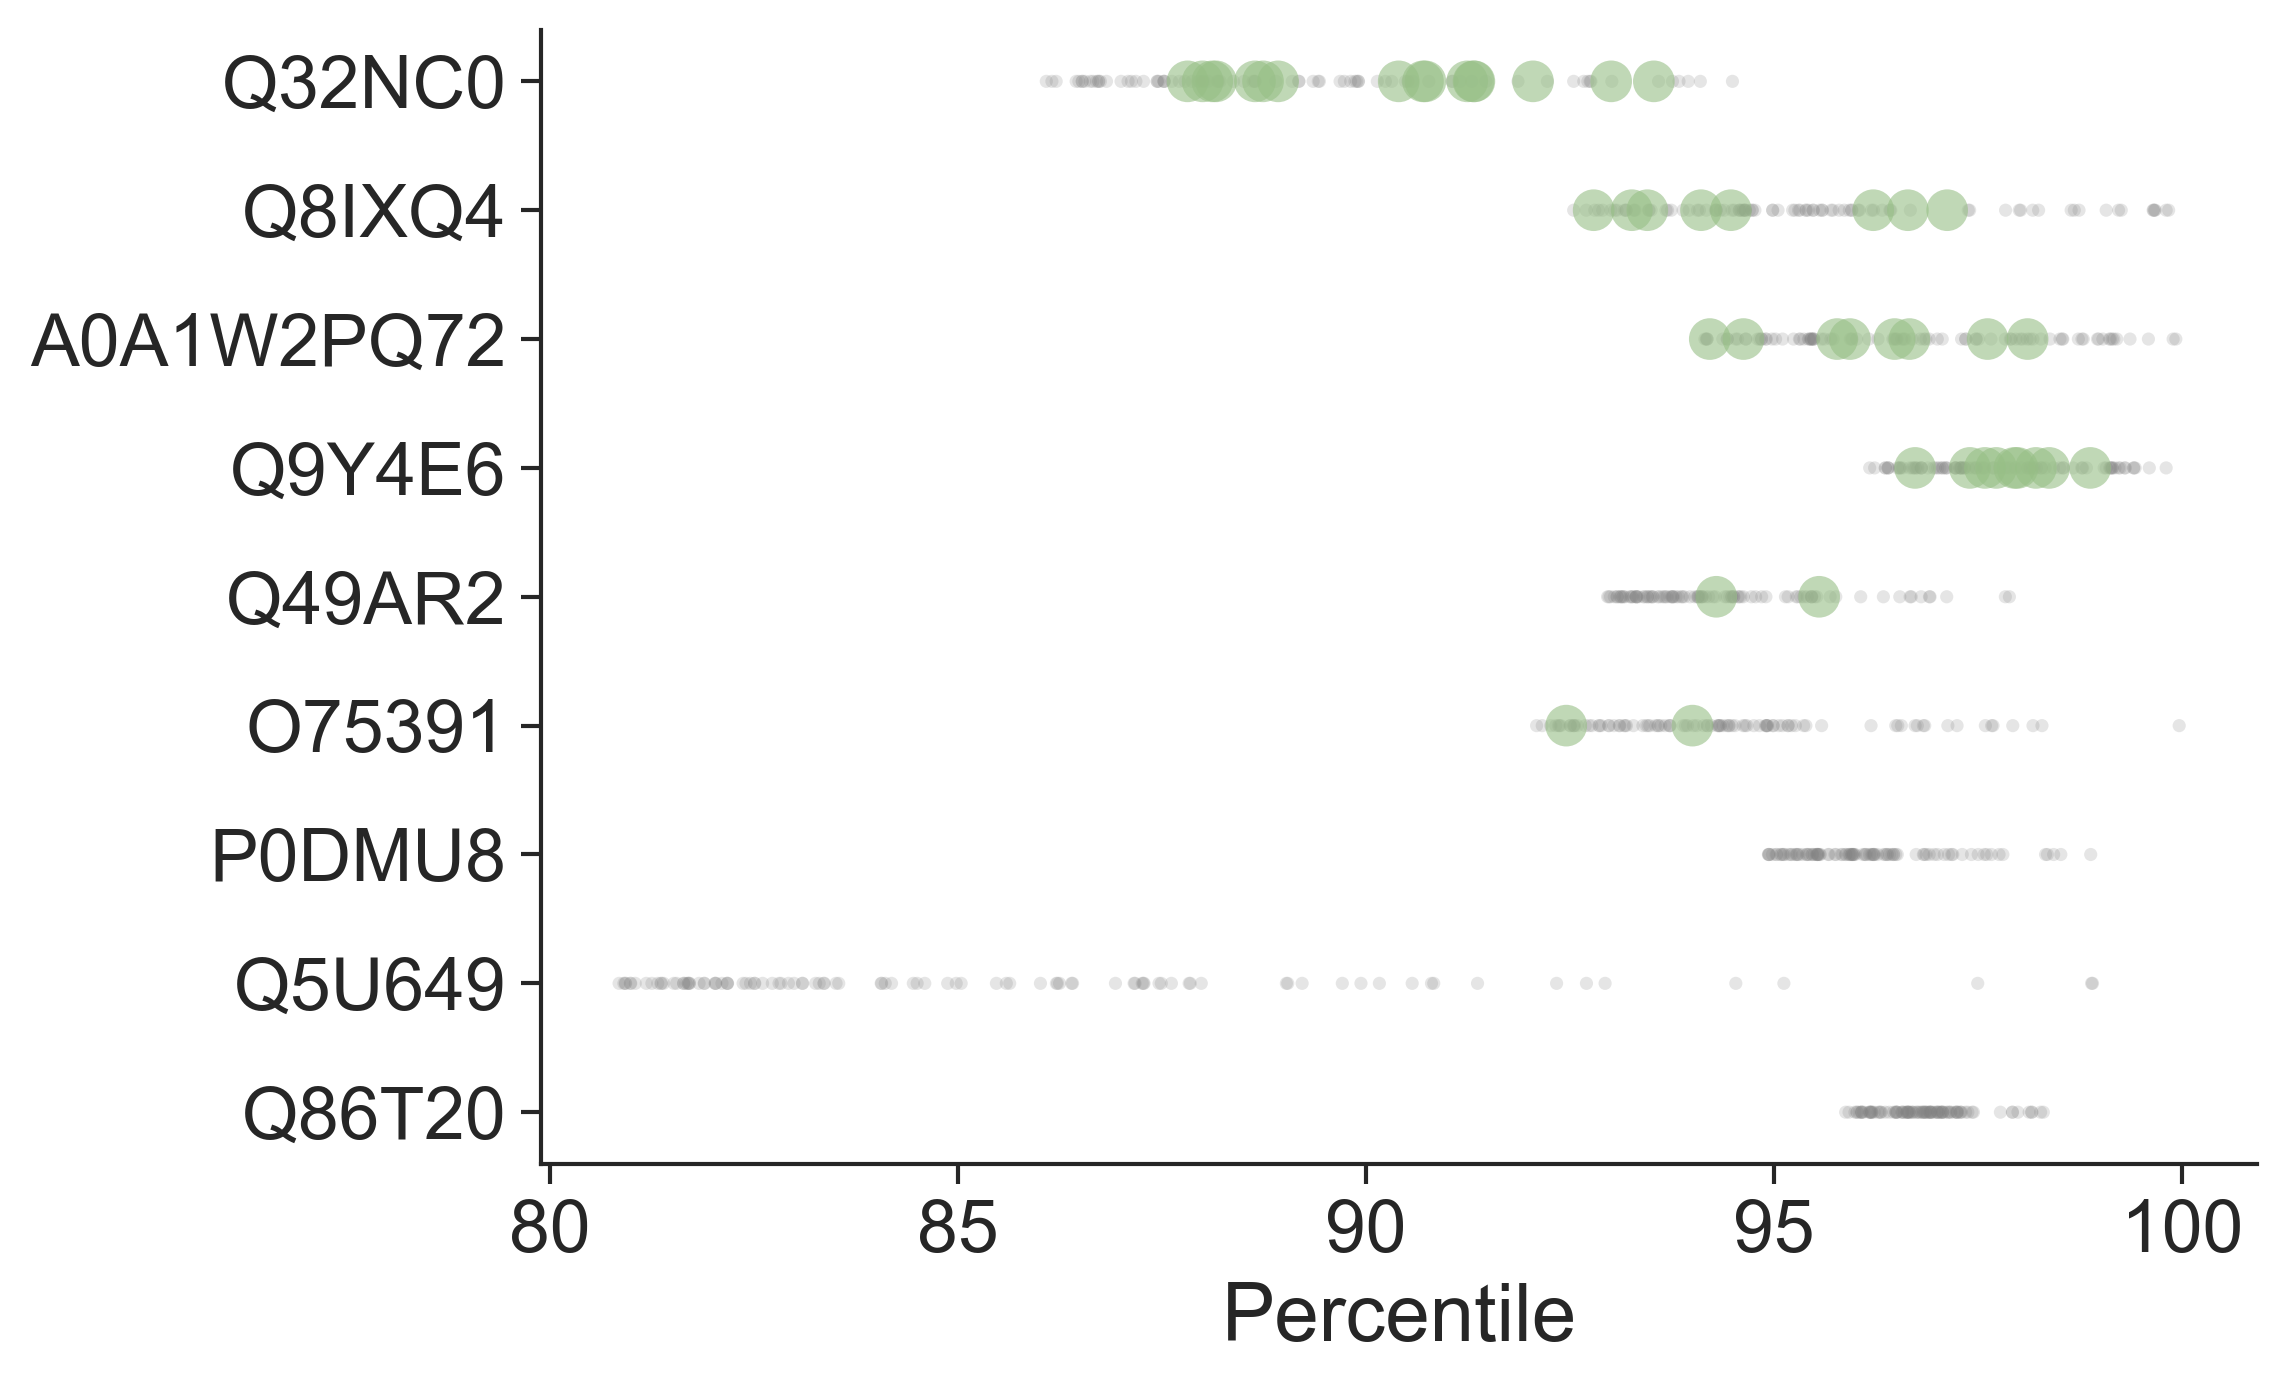

In [ ]:
plot_data["p_val"] = plot_data["protein_title"].apply(lambda x: x.split("$")[-1].strip(")"))
plot_data["p_val"] = plot_data["p_val"].replace({"":"0.001"}).astype(float)
plot_data["protein_title_no_pval"] = plot_data["protein_title"].apply(lambda x: x.split(" (")[0])

# Sort the data to ensure validated points appear on top
plot_data = plot_data.sort_values(["p_val", "ora_label"])
plot_data["ret_score_100"] = plot_data["ret_score"].apply(lambda x: 100 * x)

fig = plt.figure(figsize=(8, 5), dpi=300)
sns.set(style="ticks", font_scale=2., context="paper")

import matplotlib.font_manager as fm
fm.fontManager.addfont('Arial.ttf')
plt.rcParams["font.family"] = "Arial"

ax = sns.scatterplot(
    data=plot_data, 
    y="protein_title_no_pval", 
    x="ret_score_100", 
    hue="ora_label", 
    palette={0:to_rgba("gray", 0.2), 1:to_rgba("#97bf86", 0.6)},
    size="ora_label",
    sizes=(100, 10),
    edgecolor='none',
)

plt.xlabel("Percentile")
plt.ylabel("")
plt.tight_layout()
plt.legend().remove()
sns.despine()
plt.tight_layout()
# plt.savefig("./retrieval_protein_centric_100.svg", bbox_inches='tight', dpi=300, format="svg")
plt.show()

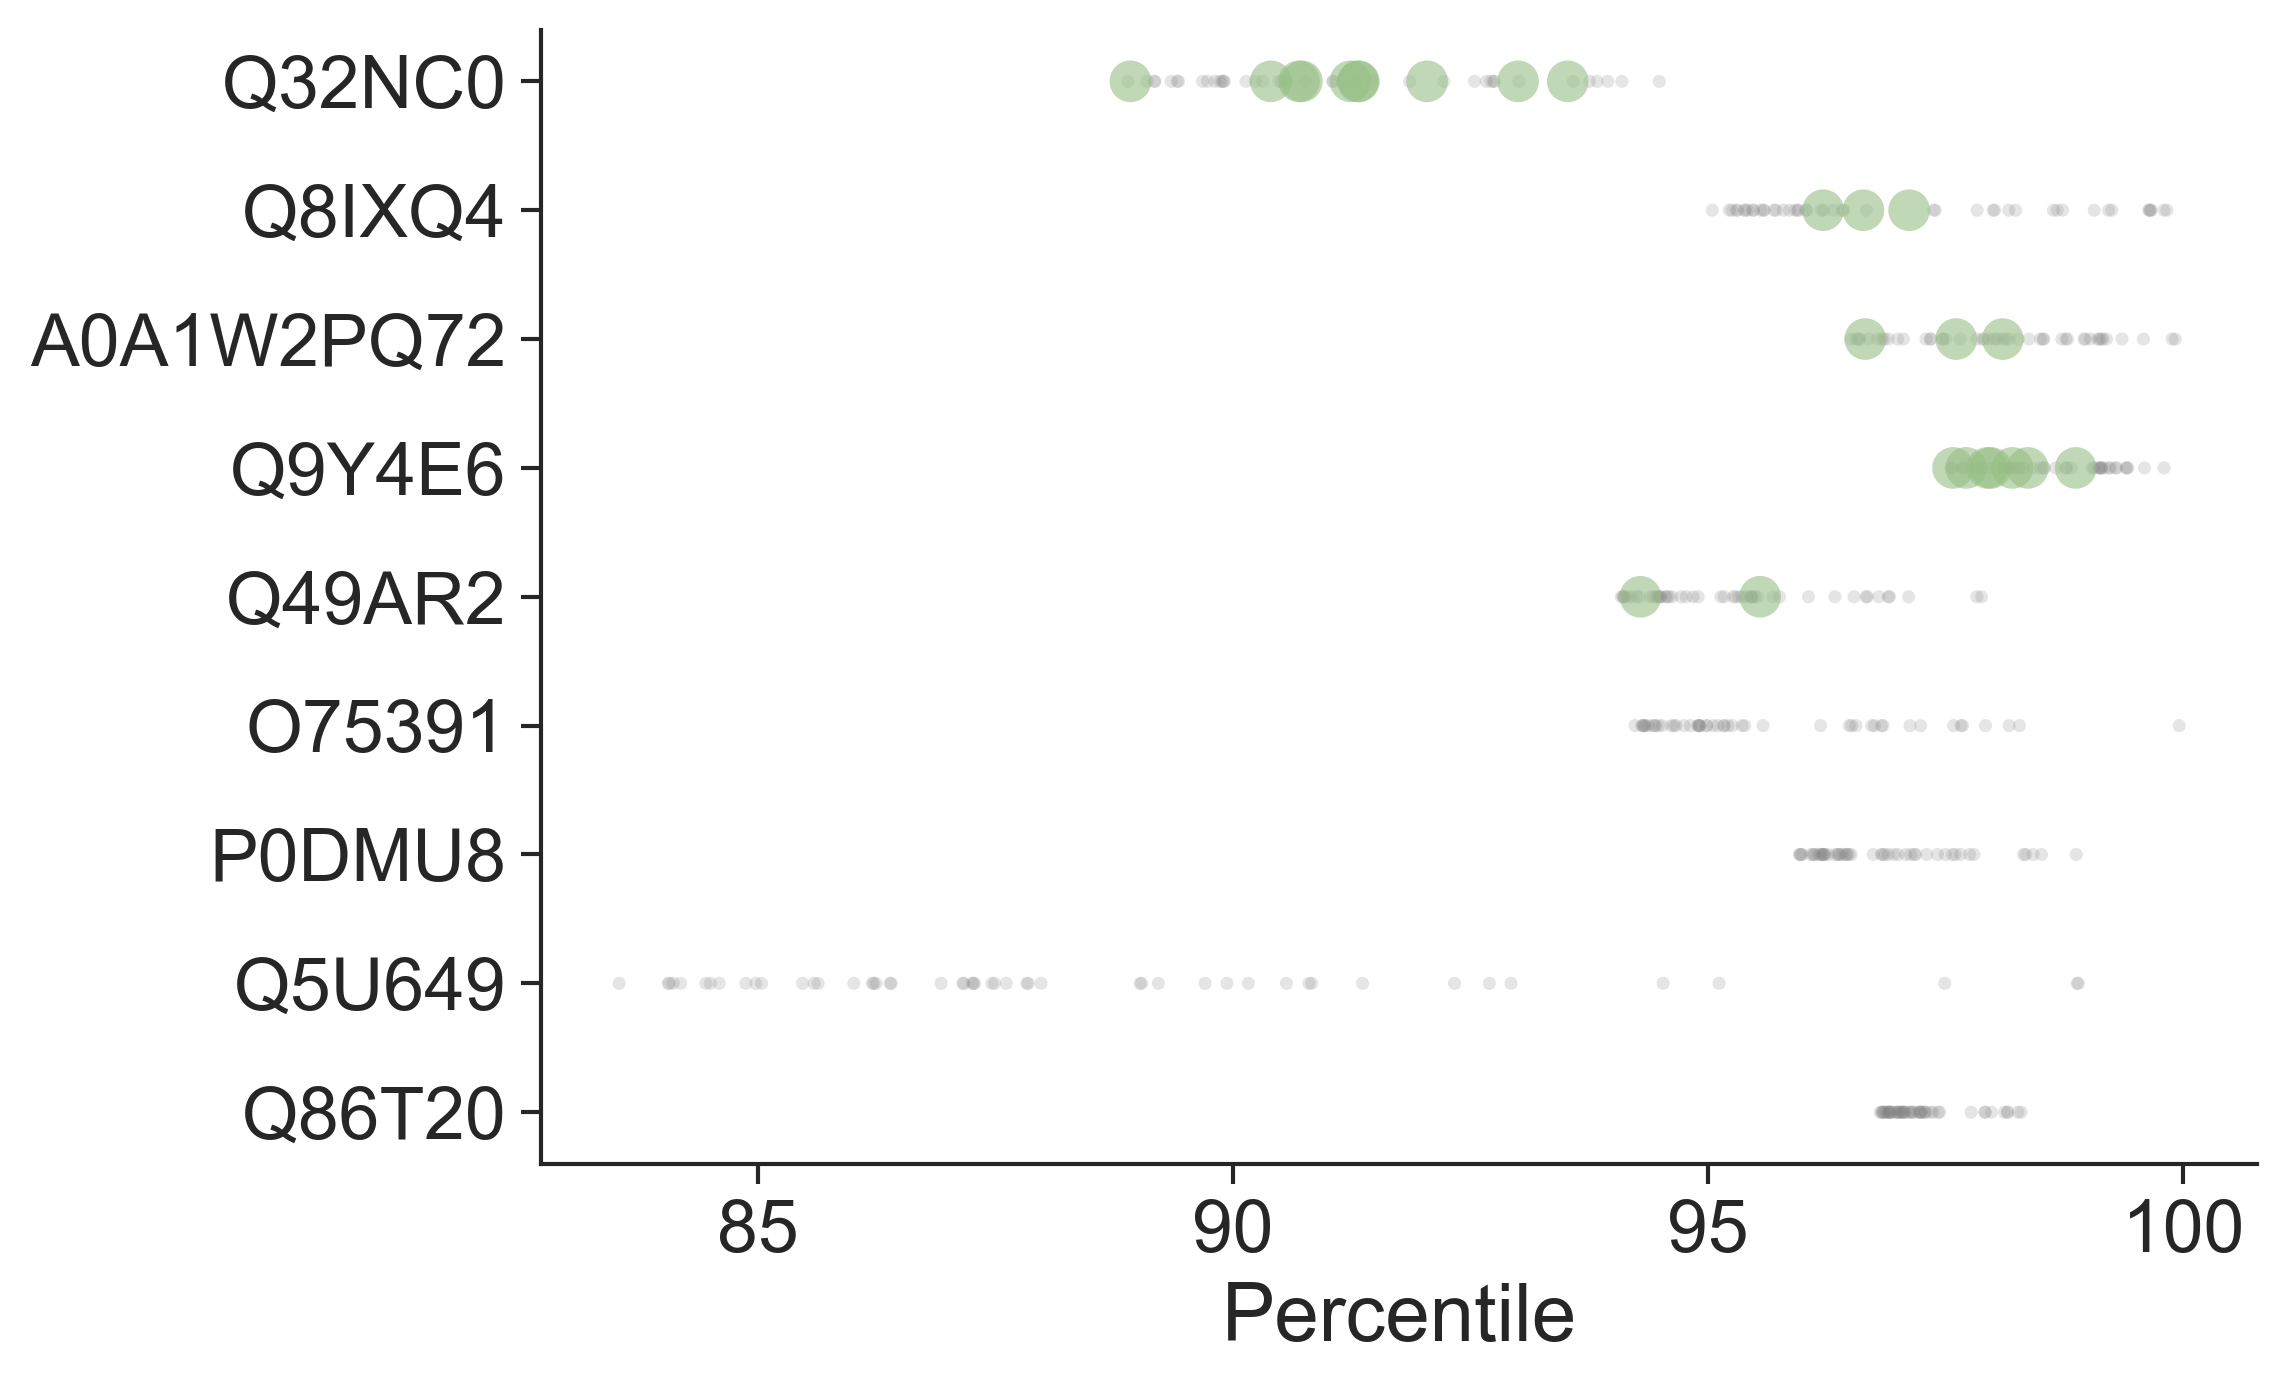

In [ ]:
plot_data_50 = []
for protein, df in plot_data.groupby("protein_title_no_pval", as_index=False):
    df_50 = df[df["ret_score_100"] >= np.quantile(df["ret_score_100"].values, 0.5)]
    plot_data_50.append(df_50)
    
plot_data_50 = pd.concat(plot_data_50, axis=0)
plot_data_50 = plot_data_50.sort_values(["p_val", "ora_label"])

fig = plt.figure(figsize=(8, 5), dpi=300)
sns.set(style="ticks", font_scale=2., context="paper")

# ax = sns.stripplot(
ax = sns.scatterplot(
    data=plot_data_50, 
    y="protein_title_no_pval", 
    x="ret_score_100", 
    hue="ora_label", 
    palette={0:to_rgba("gray", 0.2), 1:to_rgba("#97bf86", 0.6)},
    size="ora_label",
    sizes=(100, 10),
    edgecolor='none',
)

plt.xlabel("Percentile")
plt.ylabel("")
plt.tight_layout()
plt.legend().remove()
sns.despine()
plt.tight_layout()
# plt.savefig("./retrieval_protein_centric_50.svg", bbox_inches='tight', dpi=300, format="svg")
plt.show()